## Requirements

Run the following setup script first. Change `remote_data_dir` to the name of the desired data folder in Solitabay.

In [1]:
remote_data_dir = 'raw_audio_data_20211007'

*Please note that this notebook requires an upgraded `matplotlib` which will be installed below.
After the installation, Colab will prompt you to restart the environment. Please click the red RESTART button
and then Run all cells from the top.*

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

if 'google.colab' in str(get_ipython()) and not Path('/content/data').is_dir(): # we only need to run this once
    !pip install --upgrade matplotlib
    !wget -q -O /content/setup.sh https://raw.githubusercontent.com/solita/ivves-machine-spraak/main/setup.sh
    !bash /content/setup.sh $remote_data_dir
else:
    print('This notebook is only meant to be run in Google Colab.')

This notebook is only meant to be run in Google Colab.


# Principal Component Analysis (PCA) and Clustering

In this notebook we'll showcase a method of applying PCA (based on a single or multiple input files and for varying window lengths) to audio data and clustering the projected lower dimensional data via the k-means algorithm.

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from scipy import signal
from scipy.io import wavfile
from math import ceil
from sklearn.preprocessing import StandardScaler

import modules.utils as utl
import modules.pca_clustering as pcc

data_folder = Path('/content/data/converted/')
# local:
#data_folder = Path('../data/converted/')
sample_rate, samples, names = utl.load_data(data_folder, channel=0)
print(names)

Found 8 files @ 48000 Hz in /Users/niko.laaksonen/projects/machine_spraak/ivves-machine-spraak/data/converted.
['ZOOM0004_Tr34.WAV', 'ZOOM0005_Tr34.WAV', 'ZOOM0005_LR.WAV', 'ZOOM0004_Tr2.WAV', 'ZOOM0004_Tr1.WAV', 'ZOOM0005_Tr1.WAV', 'ZOOM0005_Tr2.WAV', 'ZOOM0004_LR.WAV']


## Analysis

### Window length

We first set the `window_length` which corresponds to how many sequential time steps we use as an input to PCA. The effect of this is essentially to downsample the signal into chunks spanning a longer period of time (but to still use the full data to fit the PCA). This introduces a local time dependency into each principal component. Note that this window is *not*
the same things as the window used for the FFT, but it is a second layer after the Fourier transform has already been performed.

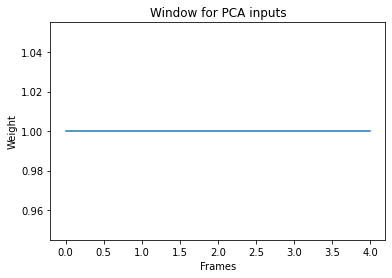

STFT window is 0.021 s.
PCA window length is 0.053 s


In [4]:
window_length = 5
stride = 3
wdw = signal.get_window('boxcar', window_length)
nperseg = 1024
noverlap = nperseg // 2
fft_params = {'window': signal.get_window(('tukey', 0.25), nperseg),
              'nperseg': nperseg,
              'noverlap': noverlap,
              'nfft': nperseg,
              'mode': 'magnitude',
              'detrend': 'constant'}
plt.plot(wdw)
plt.title('Window for PCA inputs')
plt.xlabel('Frames')
plt.ylabel('Weight')
plt.show()

f, t, s = pcc.sample2spec(np.array([samples[0]]), sample_rate, fft_params=fft_params)
print(f'PCA window length is {len(wdw) * (fft_params["nperseg"]-fft_params["noverlap"]) / sample_rate:.3f} s')

### Applying PCA

First we visualise the principal components based on a single audio sample. The color corresponds to the coefficient of each principal component in the projection of the data in a given time interval.

STFT window is 0.021 s.
Fitting new scaler


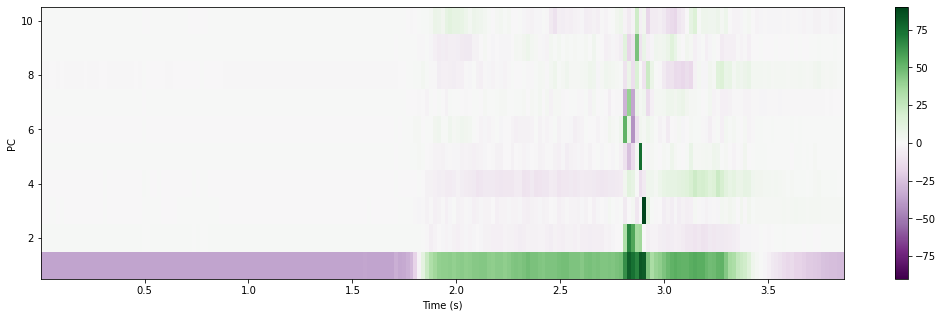

In [5]:
f, t, s = pcc.sample2spec(np.array([samples[7]]), sample_rate)
spec_pca, _, _, _ = pcc.spec2pca(s, wdw, stride=stride, n_components=10)
pcc.plot_pca(spec_pca[0], t[0])
plt.show()

We can first try to use the above principal components of a single sample (defined by `sample_to_use`) to decompose all the other samples. The source sample is highlighted in the below plot.

STFT window is 0.021 s.
Fitting new scaler


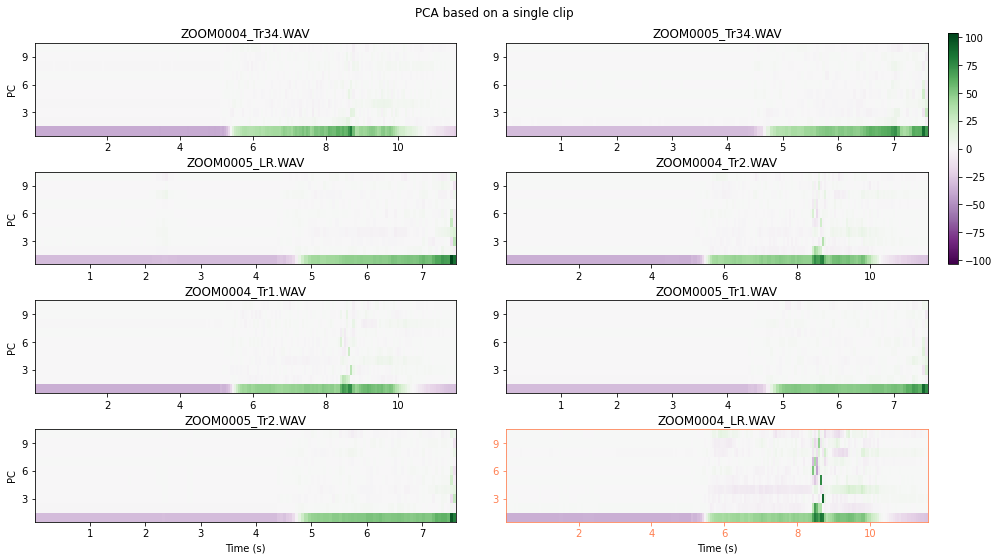

In [6]:
sample_to_use = 7

fs, ts, sxxs = pcc.sample2spec(samples, sample_rate)
# fit the pca to a single sample
_, pca, sclr, _ = pcc.spec2pca([sxxs[sample_to_use]], wdw, stride=stride, n_components=10)
spec_pcas, _, _, _ = pcc.spec2pca(sxxs, wdw, stride=stride, pca=pca, sclr=sclr)

# clip the values to aid visualisation
#for i in range(len(spec_pcas)):
#    spec_pcas[i] = np.clip(spec_pcas[i], -100, 100)

fig = pcc.plot_pca_grid(spec_pcas, ts, stride=stride, names=names, title='PCA based on a single clip',
                        hl_idx=[sample_to_use], equal_scale=True)
plt.show()

For comparison, here's PCA performed independently on each individual sample.

STFT window is 0.021 s.
Fitting new scaler
Fitting new scaler
Fitting new scaler
Fitting new scaler
Fitting new scaler
Fitting new scaler
Fitting new scaler
Fitting new scaler


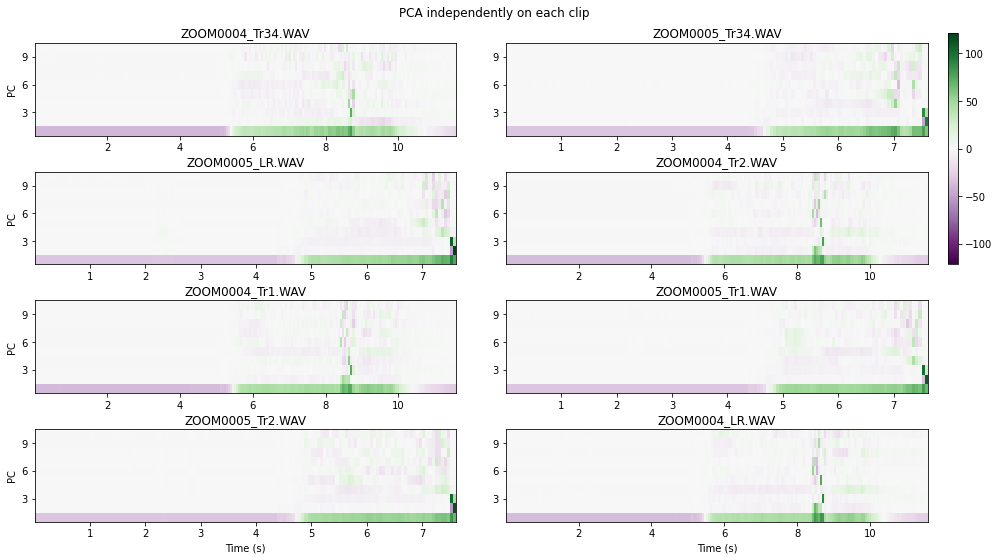

In [7]:
fs, ts, sxxs = pcc.sample2spec(samples, sample_rate)
# fit the pca to a single sample
spec_pcas = []
for sxx in sxxs:
    (sp,), _, _, _ = pcc.spec2pca([sxx], wdw, stride=stride, n_components=10)
    spec_pcas.append(sp)

pcc.plot_pca_grid(spec_pcas, ts, stride=stride, names=names, title='PCA independently on each clip',
                  equal_scale=True)
plt.show()

Finally, the most sensible thing to do (possibly?) is to perform PCA on all the chunks from the 8 different audio clips simultaneously (so that for each clip the principal components have the same "meaning").

STFT window is 0.021 s.
Fitting new scaler


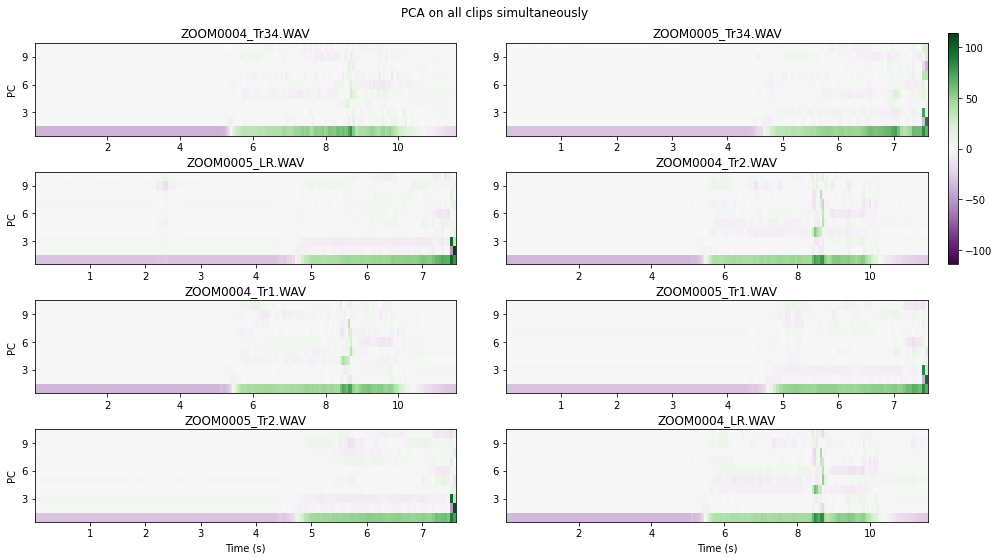

In [8]:
fs, ts, sxxs = pcc.sample2spec(samples, sample_rate)
spec_pcas, _, _, _ = pcc.spec2pca(sxxs, wdw, stride=stride, n_components=10)

pcc.plot_pca_grid(spec_pcas, ts, stride=stride, names=names, title='PCA on all clips simultaneously',
                  equal_scale=True)
plt.show()

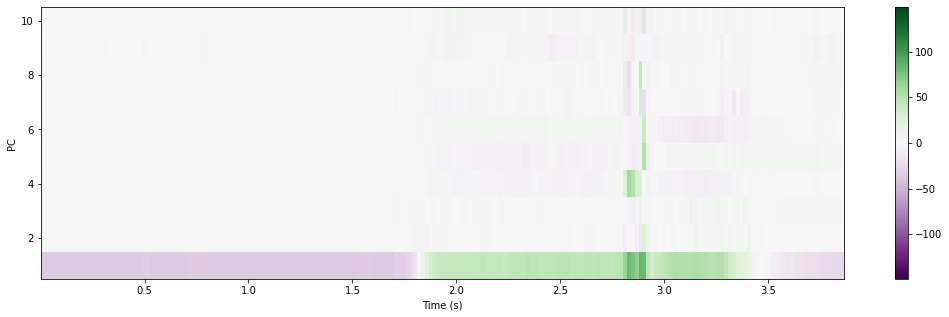

In [9]:
pcc.plot_pca(spec_pcas[7], ts[7], halfrange=148.7)
plt.show()

We can see that the first principal component heavily dominates compared to the rest (note: this does *not* mean that the components
with lowe variance are uninformative or less useful; another common misconception about PCA, for instance, try to think what does the
first principal component signify about the audio in our plots? how useful is it actually?).

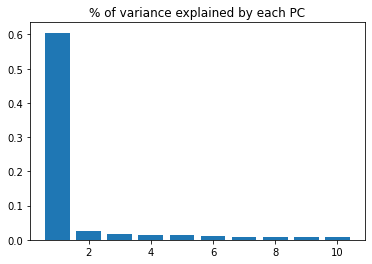

In [10]:
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title('% of variance explained by each PC')
plt.show()

## Loadings

Loadings are scaled eigenvectors of the covariance matrix $\frac{1}{N-1}X^{\mathsf{T}}X$ corresponding to the design matrix $X\in\mathbb{R}^{N\times p}$. The scaling is given by the square root of the respective eigenvalues, which are also the singular values of $X$ in the SVD decomposition $X=USV^{\mathsf{T}}$. Thus we can write the loading matrix $L$ as $$L=\frac{1}{\sqrt{N-1}}VS.$$
Since the eigenvectors are stored in `pca.components_` and the eigenvalues in `pca.explained_variance_`, we see that
```
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
```
For a short summary see <https://stats.stackexchange.com/questions/104306/what-is-the-difference-between-loadings-and-correlation-loadings-in-pca-and/104640#104640>.

**Note:** *There seems to be some confusion about the terminology depending on the source (e.g. the documentation in R refers to the eigenvectors as loadings), so bear that in mind.*

When reducing the dimensionality of the data with `pca.transform` it projects to the eigenvectors (as expected; see <https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/decomposition/_base.py#L97>).

### Visualising individual principal components

In general, when we visualise/compare principal components it makes more sense to look at the loadings. This is because in PCA the eigenvectors have norm 1 and as such don't represent quantities in the same scale as the original data (i.e. they are direction vectors). The loading matrix $L$, on the other hand, is precisely the cross-covariance matrix of $X$ with the principal components and so it has a physical meaning.

If we apply PCA with `window_length=1` then each principal component is some linear combination of distinct frequencies. On the other hand, for `window_length>1`, we have multiple dimensions in the input space that correspond to the same physical frequency (but at a time offset). We visualise both of these cases below.

#### window_length = 1

We show the filter (as a wave) corresponding to each principal component. The graph shows the weight assigned to each frequency per principal component.

STFT window is 0.021 s.
Fitting new scaler


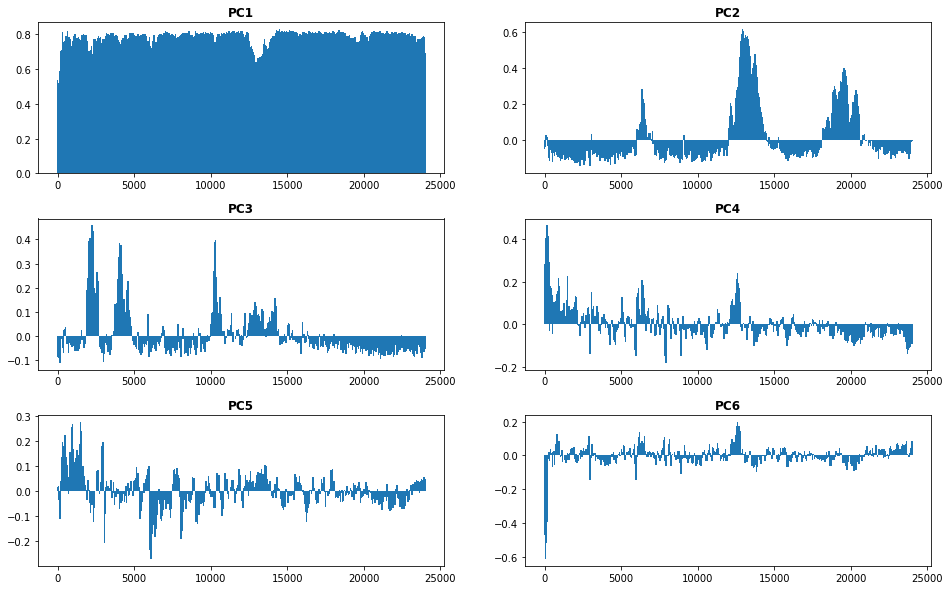

In [11]:
short_window = signal.get_window('boxcar', 1)
fs, ts, sxxs = pcc.sample2spec(samples, sample_rate)
spec_pcas, pca, sclr, _ = pcc.spec2pca(sxxs, short_window, stride=1, n_components=10)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
v = np.zeros((loadings.shape[1], len(fs[0])))
for i, _ in enumerate(loadings.T):
    v[i, :] = loadings[:, i].reshape(len(short_window), v.shape[1])

fig, axs = plt.subplots(3, 2, figsize=(16,10), gridspec_kw={'hspace':0.3})
for n, ax in enumerate(axs.flat):
    ax.bar(fs[0], v[n,:], width=100)
    ax.set_title(f'PC{n+1}', fontdict={'fontweight':'bold'}, y=1)
plt.show()

#### window_length > 1

On the other hand, for larger `window_length` we can show the time evolution of the filter corresponding to a single principal component.

STFT window is 0.021 s.
Fitting new scaler


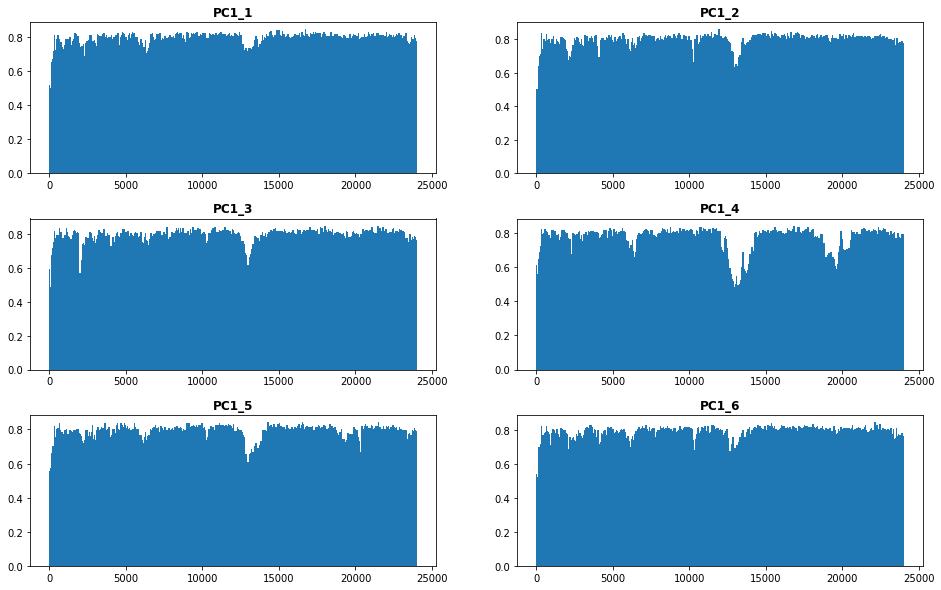

In [12]:
timesteps_to_show = 6
long_window = signal.get_window('boxcar', 6)

fs, ts, sxxs = pcc.sample2spec(samples, sample_rate)
spec_pcas, pca, sclr, _ = pcc.spec2pca(sxxs, long_window, stride=len(long_window), n_components=10)

wl = len(long_window)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
v = np.zeros((loadings.shape[1], wl, len(fs[0])))
for i, _ in enumerate(loadings.T):
    v[i, :, :] = loadings[:, i].reshape(wl, v.shape[-1])

width=100

fig, axs = plt.subplots(3, 2, figsize=(16,10), gridspec_kw={'hspace':0.3})
for n, ax in enumerate(axs.flat):
    if n >= wl or n >= timesteps_to_show:
        break
    ax.bar(fs[0], v[0, n, :], width=width)
    ax.set_title(f'PC{1}_{n+1}', fontdict={'fontweight':'bold'}, y=1)
plt.show()

## Clustering

We'll now apply simple `k`-means clustering to our data and plot the resulting reduced spectrograms.
For each time step we also signify the corresponding cluster label at the bottom of each plot.
Since the `k`-means algorithm relies on Euclidean distance it suffers from the [*curse of dimensionality*](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
and as such does not perform well with high-dimensional data.
Therefore it is crucial that we have first performed dimensionality reduction with PCA. Moreover, `k`-means algorithm has high variance so that if the clusters in the data are not well separated, then the performance of the algorithm is very unstable. However, we choose to demonstrate `k`-means here, because it is one of the simplest clustering algorithms and it is always a good idea to establish a baseline before moving on to more complicated methods :)

STFT window is 0.021 s.
Fitting new scaler


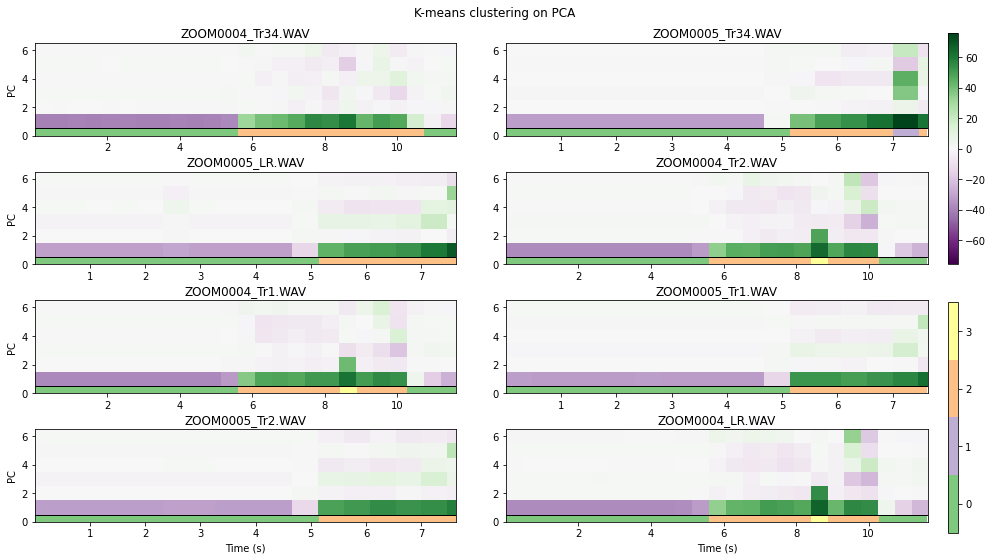

In [13]:
window_length = 25
stride=25
n_clusters = 4
n_components = 6

spec_pcas, ts, _, kmeans, pca, kmeans_sclr, _ = pcc.cluster(samples, sample_rate, wdw, stride=stride,
                                                  n_clusters=n_clusters, n_components=n_components,
                                                  max_iter=300, verbose=False)

labels = [np.repeat(kmeans.predict(kmeans_sclr.transform(s.T)), repeats=stride) for s in spec_pcas]

fig = pcc.plot_pca_grid(spec_pcas, ts, stride=stride, names=names, title='K-means clustering on PCA',
                        equal_scale=True)

# setup the colors for labels
c=cm.Accent
colors=[]
color_labels = np.arange(n_clusters)
for i in range(n_clusters):
    colors.append(c.colors[i])
tag_cmap = ListedColormap(colors)
loc = np.linspace(0, 1, n_clusters, endpoint=False)
loc = loc + 1/(2*n_clusters)

for n, ax in enumerate(fig.axes[:-1]):
    ax.pcolormesh(ts[n], np.array([0,0.5]), labels[n][np.newaxis, :len(ts[n])-1], shading='flat', cmap=tag_cmap,
                 vmin=0, vmax=n_clusters)
    ax.axhline(0.5, 0, 1, color='k', linewidth=1)

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.2/3, 0.01, 0.4])
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1.), cmap=tag_cmap), cax=cbar_ax)
cb.set_ticks(loc)
cb.set_ticklabels(color_labels)
plt.show()

Here we can zoom in on an indivual clip given by `clip_no`.

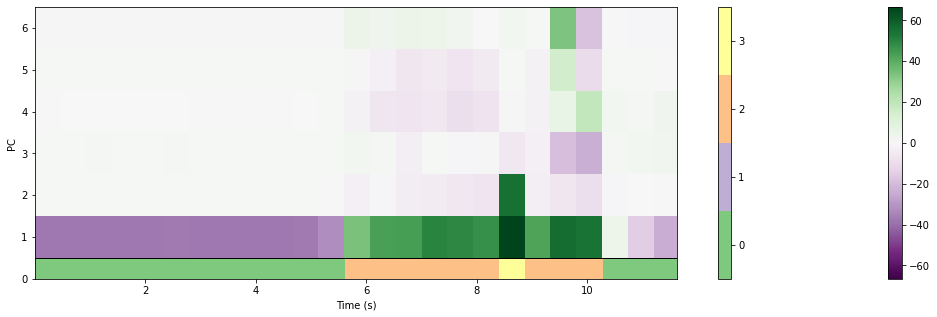

In [14]:
clip_no = 7

fig, ax = pcc.plot_pca(spec_pcas[clip_no], ts[clip_no], stride=stride)
# Note the -1 in the range of tags, this is because of shading='flat'
p = ax.pcolormesh(ts[clip_no], np.array([0,0.5]), labels[clip_no][np.newaxis, :len(ts[clip_no])-1], shading='flat', cmap=tag_cmap,
                  vmin=0, vmax=n_clusters)
ax.axhline(0.5, 0, 1, color='k', linewidth=1)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1.), cmap=tag_cmap))
cb.set_ticks(loc)
cb.set_ticklabels(color_labels)
plt.show()

### Elbow Method

To check on the effectiveness of the k-means algorithm, we look at the plot of *inertia* as a function of the number of clusters. Suppose the k-means algorithm has produced $n$ clusters $\mathcal{C}_{1},\ldots,\mathcal{C}_{n}$ with centroids $c_{1}, \ldots, c_{n}$, respectively. Then the inertia of this configuration is defined as
$$I=\sum_{i=1}^{n}\sum_{x\in\mathcal{C}_{i}}|x-c_{i}|^{2},$$
where we assume that each data point has been assigned to a cluster with minimal distance to its centroid. Notice that this is precisely the quantity that the k-means algorithm tries to minimise.

STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler


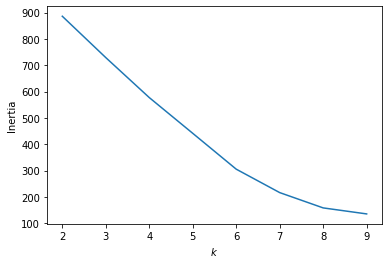

In [15]:
max_k = 10
inertias = []
for k in range(2, max_k):
    spec_pcas, ts, _, kmeans, _, _, _ = pcc.cluster(samples, sample_rate, wdw, stride=stride,
                                                    n_clusters=k, n_components=n_components,
                                                    max_iter=300, verbose=False)
    inertias.append((k, kmeans.inertia_))
    
plt.plot(*zip(*inertias))
plt.ylabel('Inertia')
plt.xlabel('$k$')
plt.show()

We notice that there is no clear "elbow" in the curve, which usually signifies that the data doesn't cluster that nicely and there is no clear optimal number of clusters.

Another metric for evaluating the performance of a clustering algorithm is the *silhouette score*. As per the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), a silhouette score for a single data point $x$ is defined as
$$s(x) = \frac{b(x)-a(x)}{\max(a(x), b(x))},$$
where $a(x)$ is the mean distance of $x$ to all the data points in its own (i.e. nearest) cluster and $b(x)$ is the minimal mean distance to the points of another cluster than that in $a(x)$. Note that $-1\leq s(x)\leq 1$, where a value of 1 signifies a perfectly defined cluster. To obtain the final silhouette score, we average $s(x)$ over the whole dataset. See also [here](https://en.wikipedia.org/wiki/Silhouette_(clustering)).

STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.
Fitting new scaler


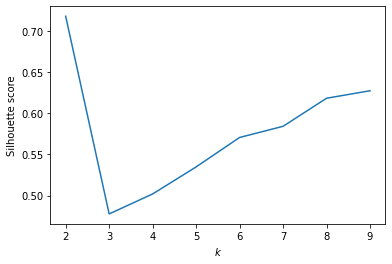

In [16]:
from sklearn.metrics import silhouette_score

max_k = 10
silhouettes = []
for k in range(2, max_k):
    spec_pcas, ts, X, kmeans, _, _, _ = pcc.cluster(samples, sample_rate, wdw, stride=stride,
                                                    n_clusters=k, n_components=n_components,
                                                    max_iter=300, verbose=False)
    silhouettes.append((k, silhouette_score(X, kmeans.labels_, metric='euclidean')))
    
plt.plot(*zip(*silhouettes))
plt.ylabel('Silhouette score')
plt.xlabel('$k$')
plt.show()

Based on this plot it seems that 3 is the least optimal number of clusters according to the silhouette score.
One should not interpret this score (or any other metric, for that matter) blindly.
In fact, depending on the problem we're trying to solve the silhouette score or inertia might not be so relevant and
ultimately the best (and the most time-consuming) solution is to investigate the clusters manually to see whether they make sense.
Depending on the nature of the data, this might not always be feasible or possible at all (if e.g. the different dimensions of the
data don't have a clear meaning).

## Train & Dev sets

Despite our small sample size, let's investigate how our algorithms perform if we use 6 clips as our training set and the two remaining ones as the dev set.
As you've noticed, when we analyse audio data we split the input signal (which could be audio recording spanning many minutes) into small windows. If we do this for
each recording of each machine we end up with a large collection of windowed data corresponding to different machines and their different states.
It would be tempting to construct your train-dev split data by randomly dividing these windows into two (and this is a mistake that can be observed in many public
blog posts and even some research articles). However, due to the nature of audio signals and the way we use overlapping FFT windows, such a procedure will almost
surely result in [*data leakage*](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), which pollutes your results and makes the model report better performance
on the validation data compared to how it will work on new unseen data.

STFT window is 0.021 s.
Fitting new scaler
STFT window is 0.021 s.


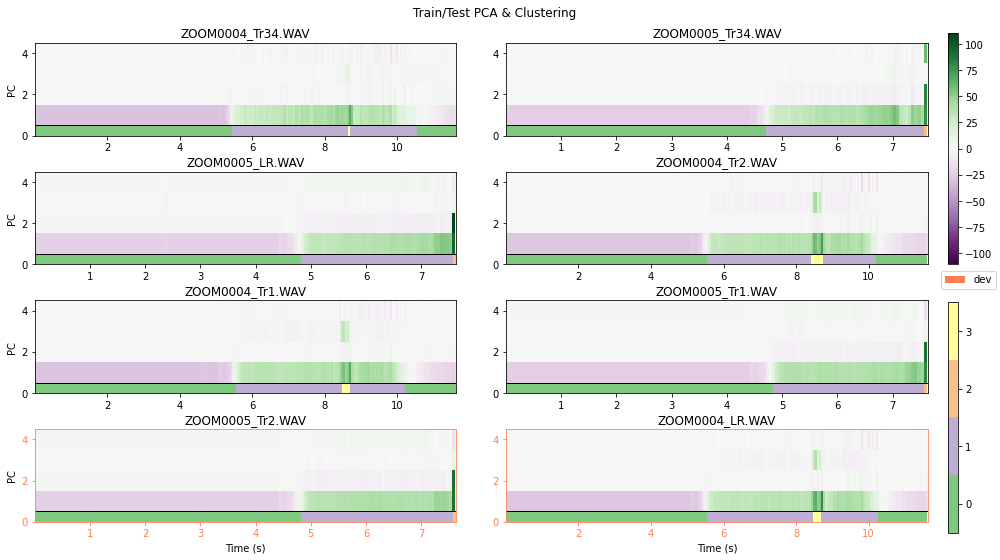

In [17]:
window_length = 3
stride = 3
wdw = signal.get_window('boxcar', window_length)
n_components = 4
n_clusters = 4
normalise = True
clip = True

s_train = samples[:6]
s_dev = samples[6:]


spec_pcas_train, ts_train, _, kmeans, pca, kmeans_sclr, pca_sclr = pcc.cluster(s_train, sample_rate, wdw, stride=stride,
                                                                               n_clusters=n_clusters, n_components=n_components)
fs, ts_dev, Sxx_dev = pcc.sample2spec(s_dev, sample_rate)
spec_pcas_dev, _, _, _ = pcc.spec2pca(Sxx_dev, wdw, stride=stride, sclr=pca_sclr, pca=pca)
spec_pcas = spec_pcas_train + spec_pcas_dev
ts = ts_train + ts_dev

labels = [np.repeat(kmeans.predict(kmeans_sclr.transform(s.T)), repeats=stride) for s in spec_pcas]

fig = pcc.plot_pca_grid(spec_pcas, ts, stride=stride, names=names, title='Train/Test PCA & Clustering', hl_idx=[6, 7],
                        hl_label='dev', equal_scale=True)

# setup the colors for labels
c=cm.Accent
colors=[]
color_labels = np.arange(n_clusters)
for i in range(n_clusters):
    colors.append(c.colors[i])
tag_cmap = ListedColormap(colors)
loc = np.linspace(0, 1, n_clusters, endpoint=False)
loc = loc + 1/(2*n_clusters)

for n, ax in enumerate(fig.axes[:-1]):
    ax.pcolormesh(ts[n], np.array([0,0.5]), labels[n][np.newaxis, :len(ts[n])-1], shading='flat', cmap=tag_cmap,
                 vmin=0, vmax=n_clusters)
    ax.axhline(0.5, 0, 1, color='k', linewidth=1)

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.2/3, 0.01, 0.4])
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1.), cmap=tag_cmap), cax=cbar_ax)
cb.set_ticks(loc)
cb.set_ticklabels(color_labels)
plt.show()

## Numpy vs sklearn

We could also perform PCA directly with `numpy` either with the eigendecomposition of the covariance matrix of the data or with an SVD decomposition.
Note that the components can differ slightly since by default `sklearn` does approximations depending on the size of the input data. Also note that it's possible that some of the axes get reversed (i.e. multiplied by -1).

In the case of SVD the correspondence is the following:

In [18]:
f, t, spec = signal.spectrogram(samples[0], sample_rate)
X = pcc.split_spec(StandardScaler().fit_transform(spec.T).T, wdw, stride=stride)
_, pca, _, _ = pcc.spec2pca([spec], wdw, stride=stride, n_components=5)

X = StandardScaler().fit_transform(X)

# S contains the singular values and the columns of U are the (scaled) principal components
U, S, V_T = np.linalg.svd(X, full_matrices=False)
V = V_T.T

Fitting new scaler


In [19]:
pca.singular_values_, S[:5]

(array([315.11768916,  95.96684775,  81.72464515,  77.50720553,
         69.46608362]),
 array([315.11768916,  95.96684778,  81.72466118,  77.50722351,
         69.4673244 ]))

In [20]:
pca.components_[:,:5], V_T[:5, :5]

(array([[ 0.03469191,  0.0327307 ,  0.06036618,  0.05330232,  0.05800032],
        [-0.00057205, -0.02701699,  0.03901592,  0.1161696 ,  0.0639373 ],
        [ 0.02943276,  0.02746   ,  0.01668744,  0.04234316,  0.0378901 ],
        [ 0.0831111 ,  0.07913711, -0.05670173, -0.05997626,  0.05486861],
        [ 0.05182716,  0.08262869,  0.01568176, -0.07501804,  0.03745141]]),
 array([[ 0.03469191,  0.0327307 ,  0.06036618,  0.05330232,  0.05800032],
        [-0.00057185, -0.02701727,  0.03901544,  0.11617013,  0.06393823],
        [ 0.02943535,  0.02743649,  0.01665952,  0.04234488,  0.03792371],
        [-0.08312042, -0.07915311,  0.0566832 ,  0.05993358, -0.05487367],
        [ 0.05159998,  0.08230688,  0.01570175, -0.0749503 ,  0.03778833]]))